In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
dataset_dir = 'brain_mri_scan_images'

In [3]:
IMAGE_SIZE = (128, 128)  # Resizing images to 128x128 for faster processing
BATCH_SIZE = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    shear_range=0.2,
    validation_split=0.2
)


In [5]:
# Training generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',         # Binary classification: tumor vs no tumor
    subset='training',
    shuffle=True
)

Found 4196 images belonging to 2 classes.


In [6]:
# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 1047 images belonging to 2 classes.


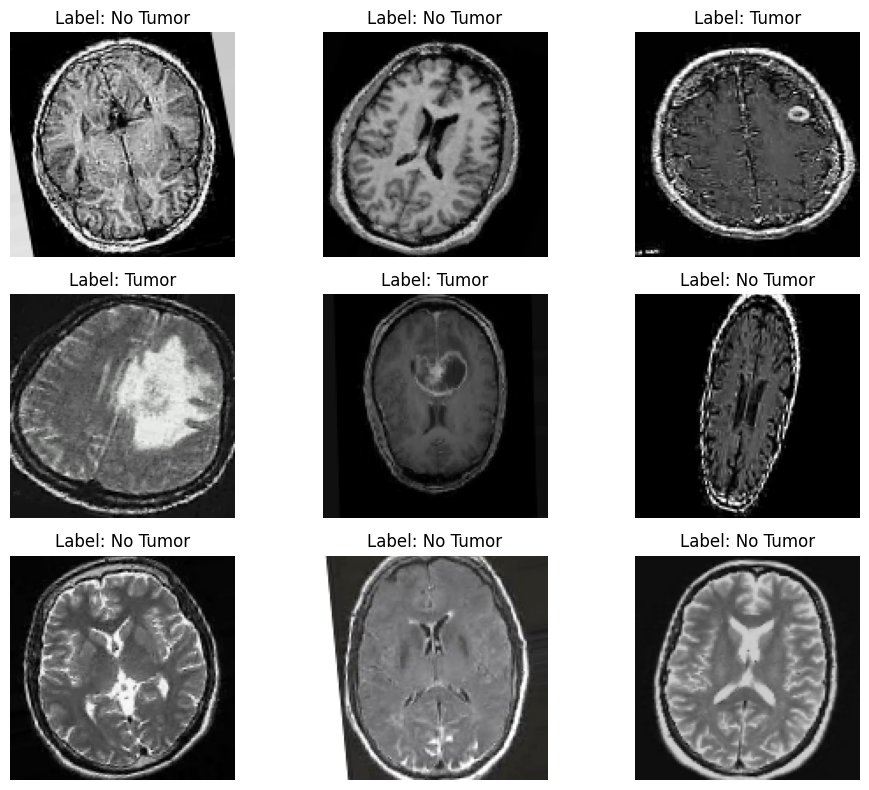

In [7]:
# Get one batch of images and labels
images, labels = next(train_generator)

# Plot 9 sample images with their labels
plt.figure(figsize=(10, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {'Tumor' if labels[i] == 1 else 'No Tumor'}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [9]:
# Build the CNN model
model = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    # Convolutional Layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    # Convolutional Layer 3
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    # Flatten + Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# Define early stopping and checkpoint to save best model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('cnn_model.h5', save_best_only=True, monitor='val_accuracy')


In [12]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.6782 - loss: 1.3929

132/132 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6784 - loss: 1.3893 - val_accuracy: 0.6896 - val_loss: 1.6496
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7338 - loss: 0.6568 - val_accuracy: 0.6877 - val_loss: 0.5852
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.7025 - loss: 0.5656

132/132 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.7025 - loss: 0.5657 - val_accuracy: 0.6925 - val_loss: 0.5674
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.7404 - loss: 0.5111

132/132 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7404 - loss: 0.5112 - val_accuracy: 0.7154 - val_loss: 0.5204
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.7367 - loss: 0.4828

132/132 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.7368 - loss: 0.4828 - val_accuracy: 0.7851 - val_loss: 0.4516
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.7616 - loss: 0.4652

132/132 ━━━━━━━━━━━━━━━━━━━━ 128s 970ms/step - accuracy: 0.7617 - loss: 0.4652 - val_accuracy: 0.8319 - val_loss: 0.3954
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 122s 924ms/step - accuracy: 0.7793 - loss: 0.4441 - val_accuracy: 0.7889 - val_loss: 0.9260
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.7926 - loss: 0.4475

132/132 ━━━━━━━━━━━━━━━━━━━━ 121s 912ms/step - accuracy: 0.7926 - loss: 0.4473 - val_accuracy: 0.8481 - val_loss: 0.3945
Epoch 9/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 125s 949ms/step - accuracy: 0.7983 - loss: 0.4328 - val_accuracy: 0.7450 - val_loss: 0.5536
Epoch 10/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 122s 921ms/step - accuracy: 0.8027 - loss: 0.3811 - val_accuracy: 0.8052 - val_loss: 0.4383
Epoch 11/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.8360 - loss: 0.3686

132/132 ━━━━━━━━━━━━━━━━━━━━ 125s 945ms/step - accuracy: 0.8360 - loss: 0.3686 - val_accuracy: 0.8586 - val_loss: 0.3094
Epoch 12/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 124s 936ms/step - accuracy: 0.8501 - loss: 0.3376 - val_accuracy: 0.8032 - val_loss: 0.4571
Epoch 13/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 126s 958ms/step - accuracy: 0.8521 - loss: 0.3313 - val_accuracy: 0.8214 - val_loss: 0.3873
Epoch 14/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 122s 924ms/step - accuracy: 0.8608 - loss: 0.3228 - val_accuracy: 0.8424 - val_loss: 0.3731
Epoch 15/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.8652 - loss: 0.2993

132/132 ━━━━━━━━━━━━━━━━━━━━ 122s 927ms/step - accuracy: 0.8653 - loss: 0.2992 - val_accuracy: 0.8825 - val_loss: 0.2658
Epoch 16/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.8762 - loss: 0.2965

132/132 ━━━━━━━━━━━━━━━━━━━━ 122s 922ms/step - accuracy: 0.8762 - loss: 0.2966 - val_accuracy: 0.8997 - val_loss: 0.2812
Epoch 17/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.8782 - loss: 0.2849

132/132 ━━━━━━━━━━━━━━━━━━━━ 126s 954ms/step - accuracy: 0.8782 - loss: 0.2849 - val_accuracy: 0.9150 - val_loss: 0.2392
Epoch 18/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.8811 - loss: 0.2676

132/132 ━━━━━━━━━━━━━━━━━━━━ 126s 957ms/step - accuracy: 0.8810 - loss: 0.2677 - val_accuracy: 0.9475 - val_loss: 0.1998
Epoch 19/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 126s 956ms/step - accuracy: 0.8897 - loss: 0.2531 - val_accuracy: 0.9074 - val_loss: 0.2321
Epoch 20/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 127s 959ms/step - accuracy: 0.8887 - loss: 0.2520 - val_accuracy: 0.9054 - val_loss: 0.2168


In [13]:
# Plot accuracy and loss curves
plt.figure(figsize=(14,5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'Accuracy over Epochs')

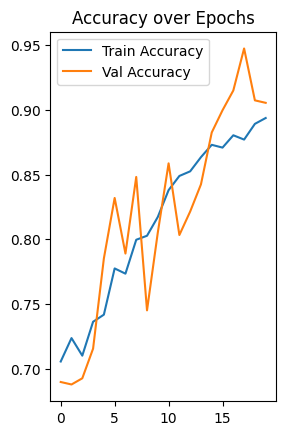

In [14]:
# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')


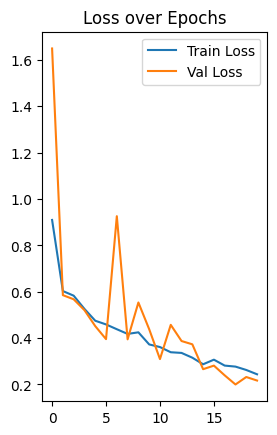

In [15]:
# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()